In [38]:
%matplotlib inline

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df_cleaned = pd.read_csv("cleaned_bgg_dataset.csv")

# Display basic information about the dataset
df_cleaned.info(), df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20327 entries, 0 to 20326
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20327 non-null  int64  
 1   Name                20327 non-null  object 
 2   Year Published      20327 non-null  int64  
 3   Min Players         20327 non-null  int64  
 4   Max Players         20327 non-null  int64  
 5   Play Time           20327 non-null  int64  
 6   Min Age             20327 non-null  int64  
 7   Users Rated         20327 non-null  int64  
 8   Rating Average      20327 non-null  float64
 9   BGG Rank            20327 non-null  int64  
 10  Complexity Average  20327 non-null  float64
 11  Owned Users         20327 non-null  int64  
 12  Mechanics           20327 non-null  object 
 13  Domains             20327 non-null  object 
dtypes: float64(2), int64(9), object(3)
memory usage: 2.2+ MB


(None,
        ID                               Name  Year Published  Min Players  \
 0  174430                         Gloomhaven            2017            1   
 1  161936          Pandemic Legacy: Season 1            2015            2   
 2  224517                  Brass: Birmingham            2018            2   
 3  167791                  Terraforming Mars            2016            1   
 4  233078  Twilight Imperium: Fourth Edition            2017            3   
 
    Max Players  Play Time  Min Age  Users Rated  Rating Average  BGG Rank  \
 0            4        120       14        42055            8.79         1   
 1            4         60       13        41643            8.61         2   
 2            4        120       14        19217            8.66         3   
 3            5        120       12        64864            8.43         4   
 4            6        480       14        13468            8.70         5   
 
    Complexity Average  Owned Users  \
 0            

In [39]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)


ID                    0
Name                  0
Year Published        0
Min Players           0
Max Players           0
Play Time             0
Min Age               0
Users Rated           0
Rating Average        0
BGG Rank              0
Complexity Average    0
Owned Users           0
Mechanics             0
Domains               0
dtype: int64


In [40]:
# Select relevant features for clustering
features = df_cleaned[['Min Players', 'Max Players', 'Play Time', 'Rating Average', 'Complexity Average']]


In [41]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Determine the Optimal Number of Clusters Using the Elbow Method

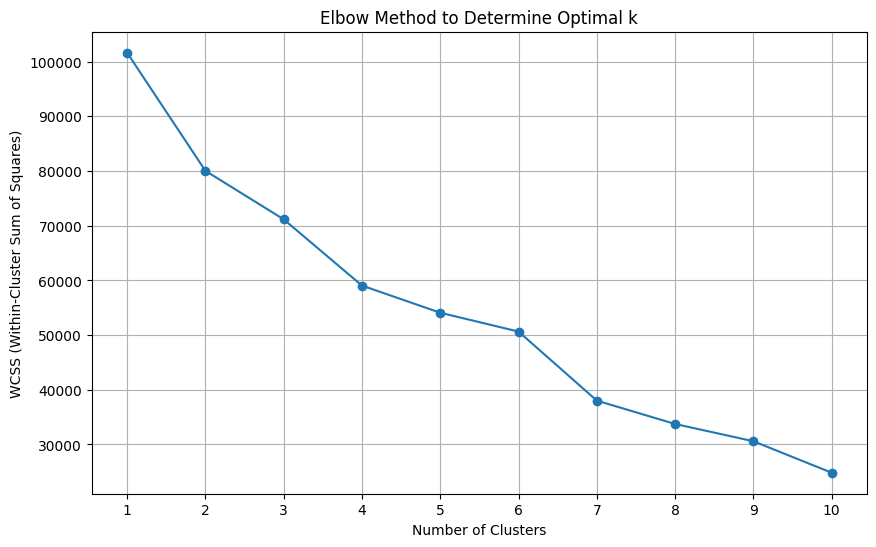

In [42]:
# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

I wanna validate k=4 or k=7,
so I calculate and compare their Silhouette Scores

k = 3, Silhouette Score = 0.32015663668986616
k = 4, Silhouette Score = 0.32104882257829587
k = 5, Silhouette Score = 0.2459600773882458
k = 6, Silhouette Score = 0.261051512751976
k = 7, Silhouette Score = 0.2675849062163629
k = 8, Silhouette Score = 0.23826959018078767


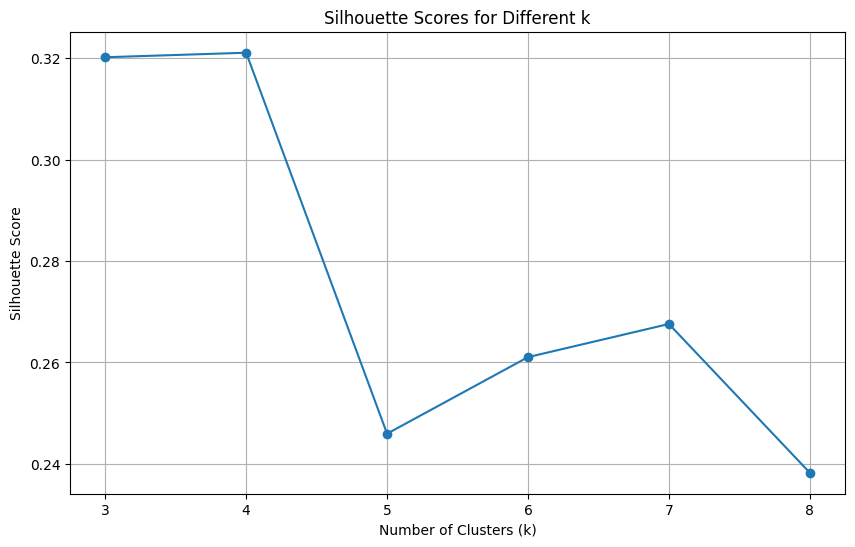

In [43]:
# Function to calculate silhouette scores for a range of k values
silhouette_scores = {}
for k in range(3, 9):  # Test k values from 3 to 8
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    score = silhouette_score(features_scaled, labels)
    silhouette_scores[k] = score
    print(f'k = {k}, Silhouette Score = {score}')

# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

Go with k=4 then

In [62]:
# # Fit K-Means with the chosen number of clusters
# optimal_k = 4  # Adjust based on the Elbow Method plot
# kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
# df_cleaned['Cluster'] = kmeans.fit_predict(features_scaled)
from scipy.stats import zscore

z_scores = pd.DataFrame(zscore(features), columns=features.columns)
threshold = 3
outliers = (z_scores.abs() > threshold).any(axis=1)
df_filtered = df_cleaned[~outliers]

print(f"Original dataset size: {df_cleaned.shape}")
print(f"Filtered dataset size: {df_filtered.shape}")

Original dataset size: (19527, 15)
Filtered dataset size: (18582, 15)


/var/folders/m2/bs2ndp296zj1k_mhdr63dk340000gn/T/ipykernel_9099/4008272793.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



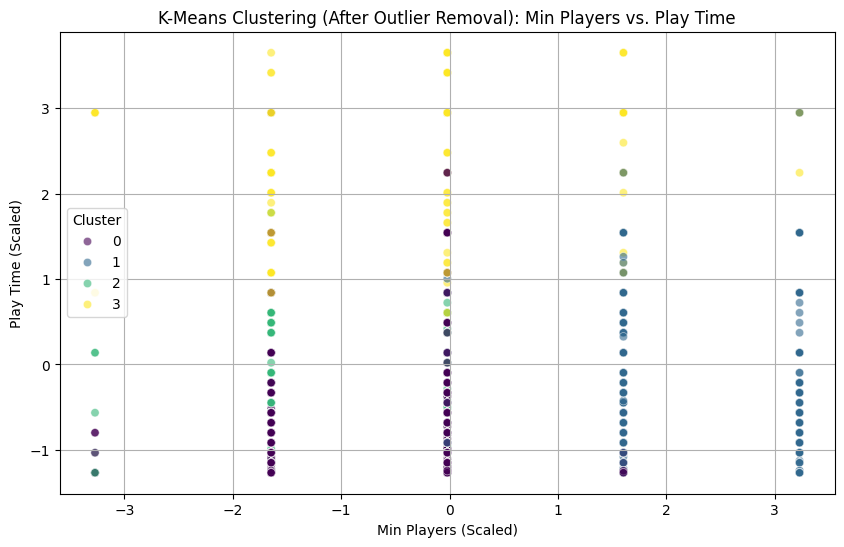

In [63]:
features_filtered = df_filtered[['Min Players', 'Max Players', 'Play Time', 'Rating Average', 'Complexity Average']]
scaler = StandardScaler()
features_scaled_filtered = scaler.fit_transform(features_filtered)

# Step 3: Refit K-Means
optimal_k = 4  # Based on earlier analysis
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
df_filtered['Cluster'] = kmeans.fit_predict(features_scaled_filtered)

# Step 4: Visualize Updated Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=features_scaled_filtered[:, 0],  # Min Players (scaled)
    y=features_scaled_filtered[:, 2],  # Play Time (scaled)
    hue=df_filtered['Cluster'],
    palette='viridis',
    alpha=0.6
)
plt.title('K-Means Clustering (After Outlier Removal): Min Players vs. Play Time')
plt.xlabel('Min Players (Scaled)')
plt.ylabel('Play Time (Scaled)')
plt.legend(title='Cluster')
plt.grid()
plt.show()

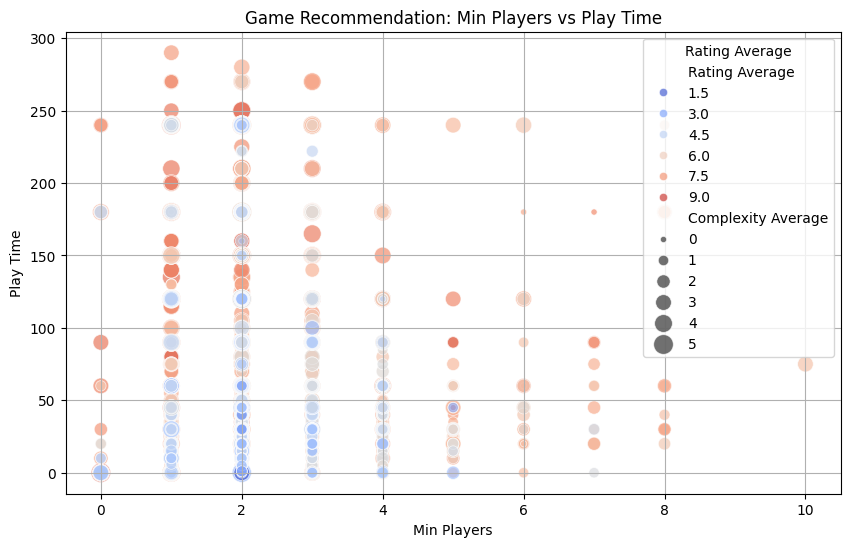

In [67]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_cleaned['Min Players'],  # Group size
    y=df_cleaned['Play Time'],  # Time required
    size=df_cleaned['Complexity Average'],  # Game complexity
    hue=df_cleaned['Rating Average'],  # Ratings
    sizes=(20, 200),  # Bubble size range
    palette='coolwarm',
    alpha=0.7
)
plt.title('Game Recommendation: Min Players vs Play Time')
plt.xlabel('Min Players')
plt.ylabel('Play Time')
plt.legend(title='Rating Average')
plt.grid()
plt.show()

In [66]:
df_cleaned = df_cleaned[df_cleaned['Play Time'] < 300]  # Example threshold

In [65]:
print(f"Features scaled shape: {features_scaled.shape}")
print(f"Cluster labels shape: {df_cleaned['Cluster'].shape}")


Features scaled shape: (19527, 5)
Cluster labels shape: (19527,)


In [52]:
# Recompute features_scaled with the same rows as df_cleaned
features = df_cleaned[['Min Players', 'Max Players', 'Play Time', 'Rating Average', 'Complexity Average']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Check PCA results
print(f"PCA result shape: {pca_result.shape}")

PCA result shape: (19527, 2)


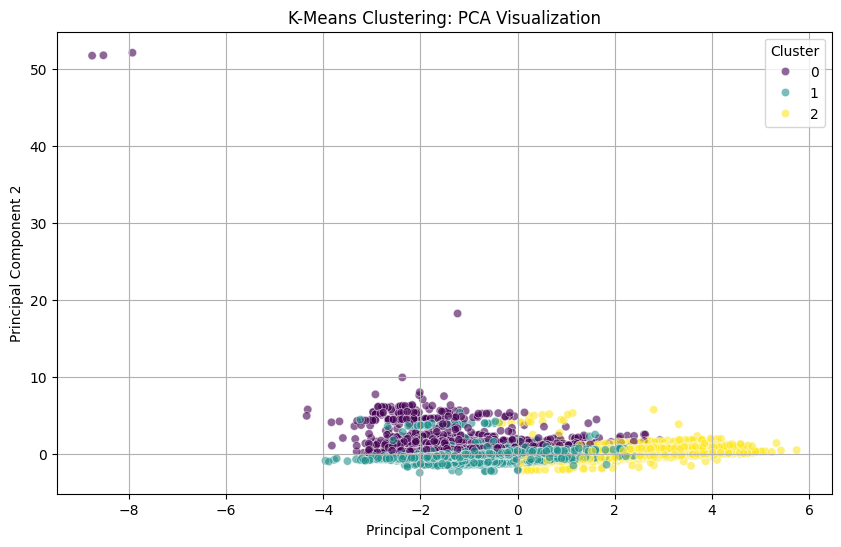

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_result[:, 0],  # First principal component
    y=pca_result[:, 1],  # Second principal component
    hue=df_cleaned['Cluster'],
    palette='viridis',
    alpha=0.6
)
plt.title('K-Means Clustering: PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

   Min Players  Max Players   Play Time  Rating Average  Complexity Average
0     1.805299     0.391360   -0.075441       -0.246705           -0.444849
1    -0.189559    -0.029823   -0.093678       -0.577663           -0.606544
2    -0.413740    -0.103258    0.127432        0.793759            0.899299
3     8.660672     0.283990  109.794048       -0.324419            3.202655


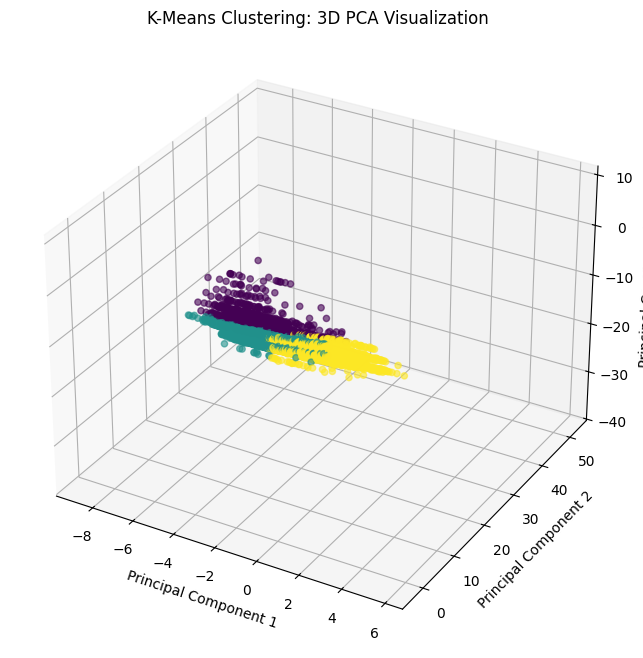

In [ ]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=features.columns)
print(cluster_centers)

# Example: Removing outliers based on Play Time
df_cleaned = df_cleaned[df_cleaned['Play Time'] < 300]  # Adjust threshold based on dataset

from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_result_3d = pca.fit_transform(features_scaled)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    pca_result_3d[:, 0], pca_result_3d[:, 1], pca_result_3d[:, 2],
    c=df_cleaned['Cluster'], cmap='viridis', alpha=0.6
)
ax.set_title('K-Means Clustering: 3D PCA Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

In [59]:
pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 17.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [60]:
import plotly.express as px
fig = px.scatter_3d(
    x=pca_result_3d[:, 0],
    y=pca_result_3d[:, 1],
    z=pca_result_3d[:, 2],
    color=df_cleaned['Cluster'].astype(str),
    labels={'color': 'Cluster'},
    title='3D PCA Visualization of Clusters'
)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed